In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install -q keras-tuner

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import kerastuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


<ipython-input-8-542d1579f453>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Nitish Dataset/train.csv')

# Display basic information and first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


(None,
    count  hate_speech_count  offensive_language_count  neither_count  class  \
 0      3                  0                         0              3      2   
 1      3                  0                         3              0      1   
 2      3                  0                         3              0      1   
 3      3                  0                         2              1      1   
 4      6                  0                         6              0      1   
 
                                                tweet  
 0  !!! RT @mayasolovely: As a woman you shouldn't...  
 1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
 2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
 3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
 4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  )

In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the tweet column
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
df.T

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,0,1,2,3,4,5,6,7,8,9,...,24773,24774,24775,24776,24777,24778,24779,24780,24781,24782
count,3,3,3,3,6,3,3,3,3,3,...,3,3,3,3,3,3,3,3,6,3
hate_speech_count,0,0,0,0,0,1,0,0,0,1,...,1,0,0,3,2,0,0,0,0,0
offensive_language_count,0,3,3,2,6,2,3,3,3,2,...,2,3,3,0,1,2,1,3,6,0
neither_count,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,3
class,2,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,1,2,1,1,2
tweet,!!! RT @mayasolovely: As a woman you shouldn't...,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...","!!!!!!""@__BrighterDays: I can not just sit up ...",!!!!&#8220;@selfiequeenbri: cause I'm tired of...,""" &amp; you might not get ya bitch back &amp; ...",""" @rhythmixx_ :hobbies include: fighting Maria...",...,you niggers cheat on ya gf's? smh....,you really care bout dis bitch. my dick all in...,"you worried bout other bitches, you need me for?",you're all niggers,you're such a retard i hope you get type 2 dia...,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,"you've gone and broke the wrong heart baby, an...",young buck wanna eat!!.. dat nigguh like I ain...,youu got wild bitches tellin you lies,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
cleaned_tweet,rt woman shouldnt complain cleaning house amp ...,rt boy dats coldtyga dwn bad cuffin dat hoe st...,rt dawg rt ever fuck bitch start cry confused ...,rt look like tranny,rt shit hear might true might faker bitch told ya,shit blows meclaim faithful somebody still fuc...,sit hate another bitch got much shit going,cause im tired big bitches coming us skinny girls,amp might get ya bitch back amp thats,hobbies include fighting mariam bitch,...,niggers cheat ya gfs smh,really care bout dis bitch dick yo feelings,worried bout bitches need,youre niggers,youre retard hope get type diabetes die sugar ...,yous muthafin lie right tl trash mine bible sc...,youve gone broke wrong heart baby drove rednec...,young buck wanna eat dat nigguh like aint fuck...,youu got wild bitches tellin lies,ruffled ntac eileen dahlia beautiful color com...


In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Split into features and labels
X = df['cleaned_tweet']
y = df['class']
X.shape, y.shape

((24783,), (24783,))

In [5]:
texts = df['cleaned_tweet'].astype(str).values
labels = df['class'].values  # 0=hate,1=offensive,2=neutral


In [6]:
#Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [9]:
# Tokenize and pad
max_words = 20000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [10]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post', truncating='post')


In [11]:
# Model‑building function for the tuner
def build_model(hp):
    model = models.Sequential()
    embed_dim = hp.Int('embed_dim', min_value=32, max_value=128, step=32)
    model.add(layers.Embedding(input_dim=max_words, output_dim=embed_dim, input_length=max_len))
    model.add(layers.GlobalAveragePooling1D())
    # 1 to 3 Dense Dropout blocks
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        rate  = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(rate))
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    # Compile
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
#Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,               # try 10 different hyperparam sets
    executions_per_trial=1,      # run each once
    directory='kt_dir',
    project_name='hate_speech'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(
    X_train_pad, y_train,
    epochs=10,
    validation_data=(X_val_pad, y_val),
    callbacks=[stop_early],
    verbose=2
)

Trial 10 Complete [00h 01m 13s]
val_accuracy: 0.8950978517532349

Best val_accuracy So Far: 0.9013516306877136
Total elapsed time: 00h 11m 02s


In [14]:
# Retrieve best model & hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param, value in best_hps.values.items():
    print(f"  {param}: {value!r}")

best_model = tuner.get_best_models(num_models=1)[0]

Best hyperparameters:
  • embed_dim: 96
  • num_layers: 1
  • units_0: 224
  • dropout_0: 0.1
  • optimizer: 'adam'


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# (Re)train the best model to convergence
history = best_model.fit(
    X_train_pad, y_train,
    epochs=20,
    validation_data=(X_val_pad, y_val),
    callbacks=[stop_early]
)

Epoch 1/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9152 - loss: 0.2330 - val_accuracy: 0.8848 - val_loss: 0.3208
Epoch 2/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9299 - loss: 0.1954 - val_accuracy: 0.9018 - val_loss: 0.2961
Epoch 3/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9368 - loss: 0.1779 - val_accuracy: 0.8971 - val_loss: 0.2988
Epoch 4/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9420 - loss: 0.1640 - val_accuracy: 0.8985 - val_loss: 0.3527
Epoch 5/20
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9417 - loss: 0.1608 - val_accuracy: 0.9011 - val_loss: 0.3013


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

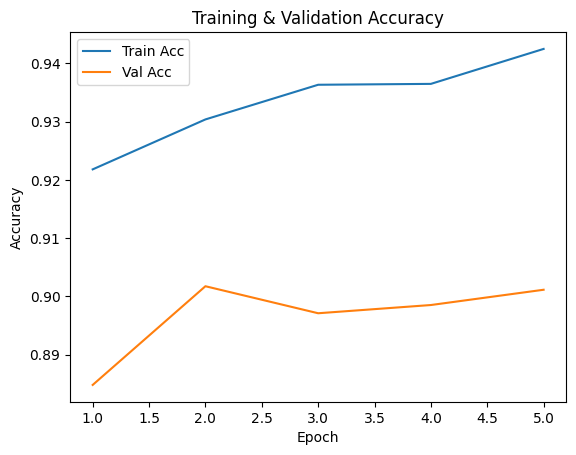

In [17]:
# Plot training & validation accuracy
acc   = history.history['accuracy']
val_a = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.figure()
plt.plot(epochs, acc,     label='Train Acc')
plt.plot(epochs, val_a,   label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

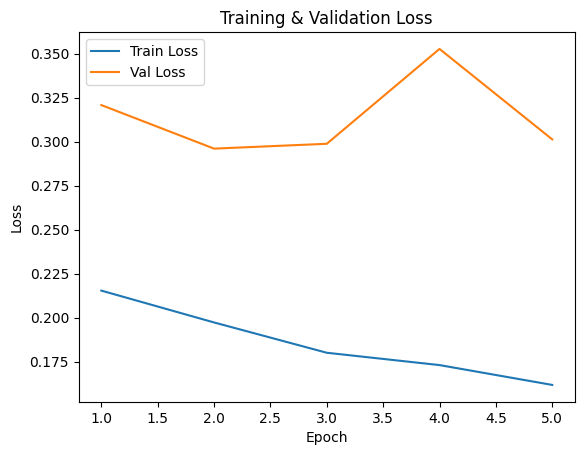

In [18]:
# 2. Plot training & validation loss
loss   = history.history['loss']
val_l  = history.history['val_loss']

plt.figure()
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_l,   label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


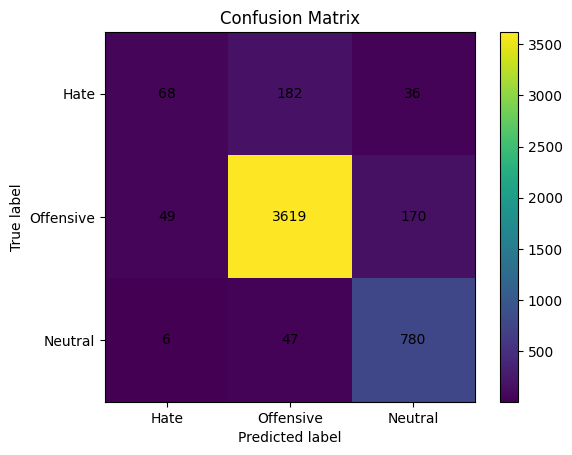

In [19]:
# Confusion matrix on validation set
y_pred_probs = best_model.predict(X_val_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_val, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0,1,2], ['Hate','Offensive','Neutral'])
plt.yticks([0,1,2], ['Hate','Offensive','Neutral'])
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.show()